<a href="https://colab.research.google.com/github/allen44/endo-us-econ-analysis/blob/main/endo_US_econ_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
GDP data is released every three month. Is it possible to forecast the next GDP dta release by using the data available before then?

Many types of econoic data are released monthly, and weekly. These data consist of numeric and non-numeric components. Using these publically available sources, this notebook will forecast the upcoming GDP release.

# Background

The objective and the input data are similar to a [research paper published by the St Louis Fed in 2016.](https://research.stlouisfed.org/publications/review/2016/12/05/a-macroeconomic-news-index-for-constructing-nowcasts-of-u-s-real-gross-domestic-product-growth/) 

In their paper, they evaluate the usefulness of a three-way linear regression model in predicting GDP. 

>Analyzing the performance of the economy in real time is a challenge for those who must forecast macroeconomic variables such as inflation or employment. A key aspect of this challenge is evaluating the incoming flow of information contained in economic announcements. In this article, the authors develop a simple-to-read index of these announcements that they then use to construct nowcasts. The index tracks whether key economic data have come in stronger, weaker, or as expected during the current quarter relative to a baseline consensus forecast. Specifically, the data releases are weighted relative to their importance in updating forecasts of real gross domestic product growth during the current quarter.

The input data that I will use differs in that I will use NLP to process the non-numeric data in the monthly ISM economic data releases to create new features to use as input to an, as of yet, unselected model.


# Imports

## Modules

In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis

import sys
from pathlib import Path

sys.path.append('/content/drive/MyDrive/Colab Notebooks/API Keys')

import config
API_KEY = config.API_KEY

working_path = Path('/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis')

/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis


In [221]:
!pip install -U tqdm requests_cache pandas-datareader hcrystalball pmdarima tbats quandl scrapy beautifulsoup4

Requirement already up-to-date: tqdm in /usr/local/lib/python3.7/dist-packages (4.61.0)
Requirement already up-to-date: requests_cache in /usr/local/lib/python3.7/dist-packages (0.6.3)
Requirement already up-to-date: pandas-datareader in /usr/local/lib/python3.7/dist-packages (0.9.0)
Requirement already up-to-date: hcrystalball in /usr/local/lib/python3.7/dist-packages (0.1.10)
Requirement already up-to-date: pmdarima in /usr/local/lib/python3.7/dist-packages (1.8.2)
Requirement already up-to-date: tbats in /usr/local/lib/python3.7/dist-packages (1.1.0)
Requirement already up-to-date: quandl in /usr/local/lib/python3.7/dist-packages (3.6.1)
     |████████████████████████████████| 256kB 22.5MB/s 
     |████████████████████████████████| 122kB 41.7MB/s 
     |████████████████████████████████| 3.1MB 34.4MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 256kB 46.5MB/s 
     |████████████████████████████████| 3.2MB 46.9MB/s 
     |███████████

In [3]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hcrystalball

## Data Sources



### Numeric data from FRED and Quandl

In [215]:
data_series_ids = {
    'fred': [
             # Money Supply
             'WM2NS', # M2 Money Stock, weekly, not seasonally adjusted

             # Interest Rates, 
             'FEDFUNDS', # IR% : Effective Federal Funds Rate, monthly

             # Inflation: Consumer and Business Inflation 
             'CPIAUCSL', # CPI: Consumer Price Index for All Urban Consumers: All Items in U.S. City Average
             'CPILFESL', # CPI Core: Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average
             'WPSFD49207', # PPI: Producer Price Index by Commodity: Final Demand: Finished Goods, Monthly
             'WPSFD4131', # PPI Core: Producer Price Index by Commodity: Final Demand: Finished Goods Less Foods and Energy, Monthly

             # Employment
             # Employemnt Situation Report: http://data.bls.gov/pdq/SurveyOutputServlet?request_action=wh&graph_name=CE_cesbref1 
             'PAYEMS', # All Employees, Total Nonfarm

             # Balance Sheets and Sovereign Risk
             'GFDEGDQ188S', # Federal Debt: Total Public Debt as Percent of GDP, Seasonally Adjusted
             'FYFSDFYGDP', # Federal Surplus or Deficit [-] as Percent of GDP
             'FYOIGDA188S', # Federal Outlays: Interest as Percent of GDP
             'W018RC1Q027SBEA', # Federal government total receipts, Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly
             'W019RCQ027SBEA', # Federal government total expenditures, Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly,
             'A091RC1Q027SBEA', # Federal government current expenditures: Interest payments, Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly
             'WGS10YR', # 10-Year Treasury Constant Maturity Rate
             'WALCL', #  CB Balance Sheet: Assets: Total Assets: Total Assets (Less Eliminations from Consolidation): Wednesday Level, Units: Millions of U.S. Dollars, Not Seasonally Adjusted
             
             # GDP, Target 
             'GDPC1', # target:  Real Gross Domestic Product, chained 2012 dollars
             'GDP', # Gross Domestic Product (GDP), Units: Billions of Dollars, Seasonally Adjusted Annual Rate
             'A191RP1Q027SBEA', # GDP Growth, Percent Change from Preceding Period, Seasonally Adjusted Annual Rate
             'STLENI', # St Louis Fed's Real GDP NOwcast, Percent Change at Annual Rate, Seasonally Adjusted Annual Rate, Quarterly


             # Consumer Sentiment
             'UMCSENT',  # Michigan sentiment starting in 1978

             # Building Permits
             'PERMIT', # New housing construction building  permits issued, monthly, seasonally adjusted annualized rate.

             # plotting helper
             'USRECD', # NBER Recession indicator
    ],
    
    'quandl': {
              'ISM/MAN_PMI': None,
              # 'ISM/MAN_DELIV': None,
              # 'ISM/MAN_CUSTINV': None,
              # 'ISM/MAN_PRICES': None,
              # 'ISM/MAN_EMPL': None,
              # 'ISM/MAN_NEWORDERS': None,
              # 'ISM/MAN_BACKLOG': None,
              # 'ISM/MAN_PROD': None,
              # 'ISM/MAN_EXPORTS': None,
              # 'ISM/MAN_INVENT': None,
              # 'ISM/MAN_IMPORTS': None,
              # 'ISM/BUY_PROD_MAT': None,
              # 'ISM/BUY_MRO_SUPP': None,
              # 'ISM/BUY_CAP_EXP': None,
              'ISM/NONMAN_NMI': None,
              # 'ISM/NONMAN_BUSACT': None,
              # 'ISM/NONMAN_EMPL': None,
              # 'ISM/NONMAN_NEWORD': None,
              # 'ISM/NONMAN_DELIV': None,
              # 'ISM/NONMAN_EXPORTS': None,
              # 'ISM/NONMAN_INVENT': None,
              # 'ISM/NONMAN_BACKLOG': None,
              # 'ISM/NONMAN_IMPORTS': None,
              # 'ISM/NONMAN_PRICES': None,
              # 'ISM/NONMAN_INVSENT': None,
              }
  }
                      


In [5]:
import pandas_datareader
import datetime
import requests_cache

expire_after = datetime.timedelta(days=7)
session = requests_cache.CachedSession(cache_name='us_econ_analysis', expire_after=expire_after)
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.today()

series_id_list = data_series_ids['fred']
params = {
    'api_key': API_KEY['fred'],
    'limit': 100000,
                }
df = pandas_datareader.fred.FredReader(series_id_list, 
                                       start, end, 
                                       session=session).read()

df.index = df.index.rename('date')

# Rename weekly and monthly data series with descriptive names
weekly_data_series = {'WM2NS': 'M2'}
monthly_data_series = {'FEDFUNDS': 'IR',
                       'CPIAUCSL': 'CPI',
                       'CPILFESL': 'CPI_Core',
                       'WPSFD49207': 'PPI',
                       'WPSFD4131': 'PPI_Core',
                       'PAYEMS': 'Employment',
                       'PERMIT': 'building_permits'
                      }

# Calculate changes in weekly and monthly data, then drop raw data
for series_id, new_name in weekly_data_series.items():
  for periods in [1, 2, 3, 4, 12]:
    df[f'{new_name}_{periods}W_pct_change'] = df[series_id].dropna().pct_change(periods=periods) * 100
  df = df.drop(columns=[series_id])

for series_id, new_name in monthly_data_series.items():
  for periods in [1, 2, 3]:
    df[f'{new_name}_{periods}M_pct_change'] = df[series_id].dropna().pct_change(periods=periods) * 100
  df = df.drop(columns=[series_id])

# Balance Sheets and Sovereign Risk
df = df.rename(columns={'GFDEGDQ188S': 'debt_as_pct_of_gdp',
                        'FYFSDFYGDP': 'surplus_or_deficit_as_pct_of_gdp',
                        'FYOIGDA188S': 'interest_payments_as_pct_of_gdp',
                        'WGS10YR': '10_year_rates',
                        'W018RC1Q027SBEA': 'total_receipts',
                        'W019RCQ027SBEA': 'total_expenditures',
                        'A091RC1Q027SBEA': 'interest_payments',
                        'WALCL': 'central_bank_total_assets',})
# Calculate useful ratios then drop raw data
df['liquidity_cover_ratio'] = (df['total_receipts'] / 
                               (df['interest_payments'].fillna(method='ffill')))

df['central_bank_total_assets_as_pct_of_gdp'] = (df['central_bank_total_assets']/1000 /
                                                 (df['GDP'].fillna(method='ffill')) * 100)  # already in billions
df = df.drop(columns=['total_receipts',
                      'interest_payments',
                      'total_expenditures',
                      'central_bank_total_assets',])

# GDP
df = df.rename(columns={'A191RP1Q027SBEA': 'gdp_growth',
                        'STLENI': 'gdp_growth_nowcast'})
df = df.drop(columns=['GDPC1', 'GDP'])

# Sentiment
df = df.rename(columns={'UMCSENT': 'michigan_consumer_sentiment'})

# Plotting helpers
df['is_recession'] = df['USRECD'].astype(bool)
df = df.drop(columns=['USRECD'])


# Data from a second data source, Quandl
import quandl
quandl.ApiConfig.api_key = API_KEY['quandl']

quandl_df_s = {}
for series_id in list(data_series_ids['quandl'].keys()):
  pref = series_id.replace('ISM/', '')
  quandl_df_s[series_id] = (quandl.get(series_id)
                              .add_prefix(f'{pref}_'))
q = pd.concat(list(quandl_df_s.values()), axis=1)

df = df.join(q, how='outer')
df.index = df.index.rename('date')



In [6]:
df.fillna(method='ffill')

,debt_as_pct_of_gdp,surplus_or_deficit_as_pct_of_gdp,interest_payments_as_pct_of_gdp,10_year_rates,gdp_growth,gdp_growth_nowcast,michigan_consumer_sentiment,M2_1W_pct_change,M2_2W_pct_change,M2_3W_pct_change,M2_4W_pct_change,M2_12W_pct_change,IR_1M_pct_change,IR_2M_pct_change,IR_3M_pct_change,CPI_1M_pct_change,CPI_2M_pct_change,CPI_3M_pct_change,CPI_Core_1M_pct_change,CPI_Core_2M_pct_change,CPI_Core_3M_pct_change,PPI_1M_pct_change,PPI_2M_pct_change,PPI_3M_pct_change,PPI_Core_1M_pct_change,PPI_Core_2M_pct_change,PPI_Core_3M_pct_change,Employment_1M_pct_change,Employment_2M_pct_change,Employment_3M_pct_change,building_permits_1M_pct_change,building_permits_2M_pct_change,building_permits_3M_pct_change,liquidity_cover_ratio,central_bank_total_assets_as_pct_of_gdp,is_recession,MAN_PMI_PMI,NONMAN_NMI_Index
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1900-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1900-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1900-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1900-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1900-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-22,129.09116,-4.6399,1.64643,1.64,11.0,7.67,84.9,0.577466,-0.190198,-0.163634,-0.585513,4.034308,0.0,-12.5,-22.222222,0.770035,1.394964,1.75456,0.916619,1.258236,1.360985,0.279981,1.559546,3.119002,0.609185,0.892857,1.082863,0.184668,0.7231,1.101334,-1.253561,0.405562,-7.966012,7.331581,35.913485,True,60.7,62.7
2021-05-23,129.09116,-4.6399,1.64643,1.64,11.0,7.67,84.9,0.577466,-0.190198,-0.163634,-0.585513,4.034308,0.0,-12.5,-22.222222,0.770035,1.394964,1.75456,0.916619,1.258236,1.360985,0.279981,1.559546,3.119002,0.609185,0.892857,1.082863,0.184668,0.7231,1.101334,-1.253561,0.405562,-7.966012,7.331581,35.913485,True,60.7,62.7
2021-05-24,129.09116,-4.6399,1.64643,1.64,11.0,7.67,84.9,0.577466,-0.190198,-0.163634,-0.585513,4.034308,0.0,-12.5,-22.222222,0.770035,1.394964,1.75456,0.916619,1.258236,1.360985,0.279981,1.559546,3.119002,0.609185,0.892857,1.082863,0.184668,0.7231,1.101334,-1.253561,0.405562,-7.966012,7.331581,35.913485,True,60.7,62.7


### Textual data from ISM surveys

In [220]:
# Todo:
# 1. Webscrape the historical publications from url_list:
import scrapy
import bs4

page_nums = [1, 2, 3, 4]
urls = {}
for page in page_nums:
  urls[page] = f'https://www.prnewswire.com/news/institute-for-supply-management/?page={page}&pagesize=100'
urls

# 2.  

ModuleNotFoundError: ignored

# EDA

In [33]:
df['is_recession'].value_counts().values

array([33761, 10580])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


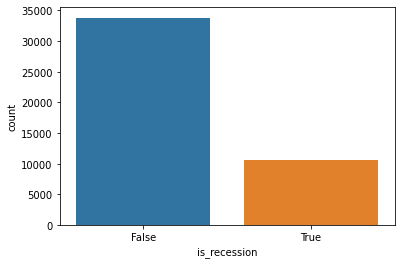

In [36]:
sns.countplot(df['is_recession'])

## Money Supply, Inflation, and Employment Measures

In [179]:
# Plotting functions

def plot_subset_together(subset: list, ref_line=0):
  ax = sns.histplot(df[subset])
  if type(ref_line) != None:
    ax.axvline(ref_line, color='grey', linestyle='--')

def plot_subset(subset: list, ref_line=0):
  for col in subset:
    fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)
    sns.scatterplot(data=df, x='date', y=col, ax=axes[0], hue='is_recession')
    sns.histplot(data=df, y=col, hue='is_recession', ax=axes[1])
    sns.boxplot(data=df, y=col, x='is_recession', ax=axes[2])
    if type(ref_line) != type(None):
      for ax in axes:
        ax.axhline(ref_line, color='grey', linestyle='--')
    plt.tight_layout()

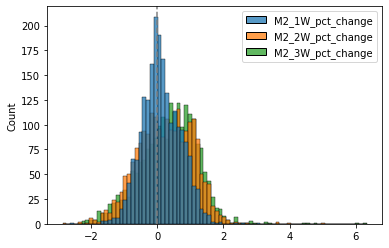

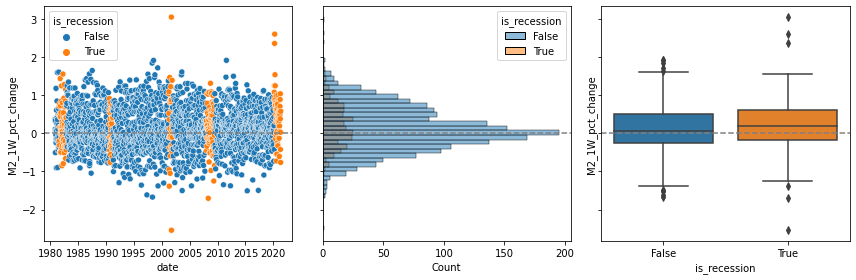

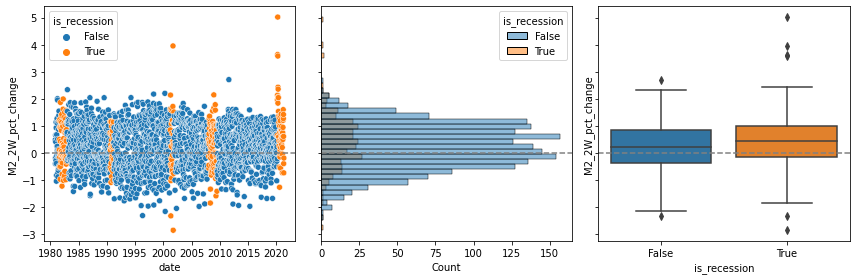

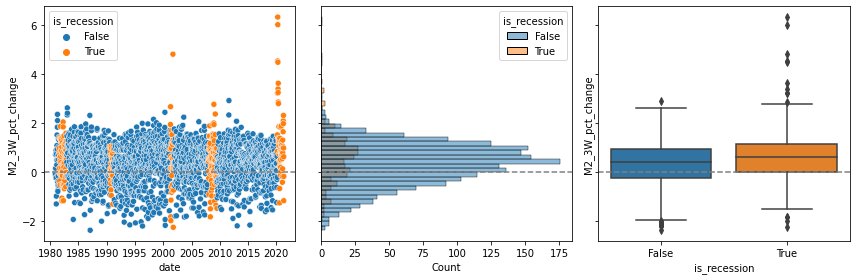

In [177]:
subset = ['M2_1W_pct_change', 'M2_2W_pct_change', 'M2_3W_pct_change']

plot_subset_together(subset)
plot_subset(subset)

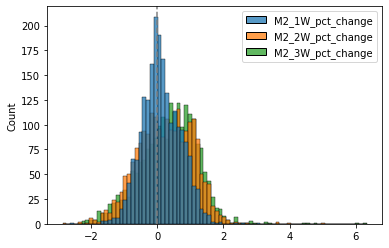

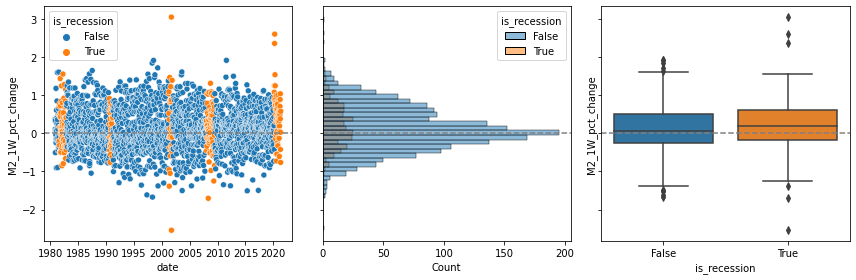

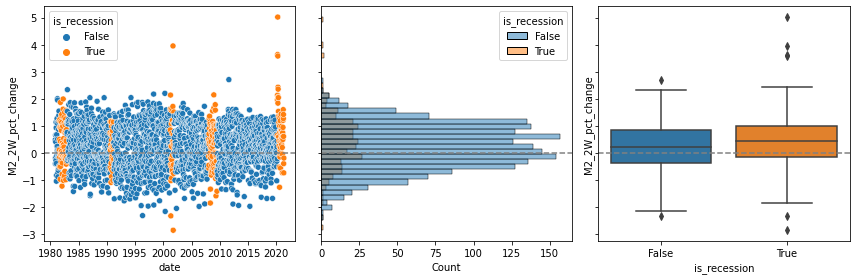

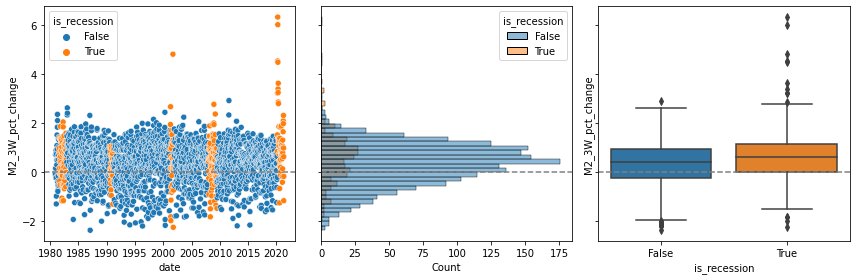

In [163]:
subset = ['M2_1W_pct_change', 'M2_2W_pct_change', 'M2_3W_pct_change']

plot_subset_together(subset)
plot_subset(subset)

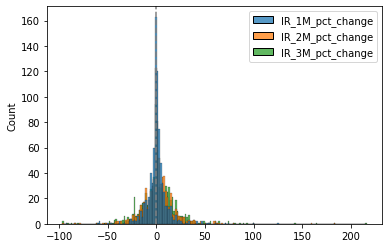

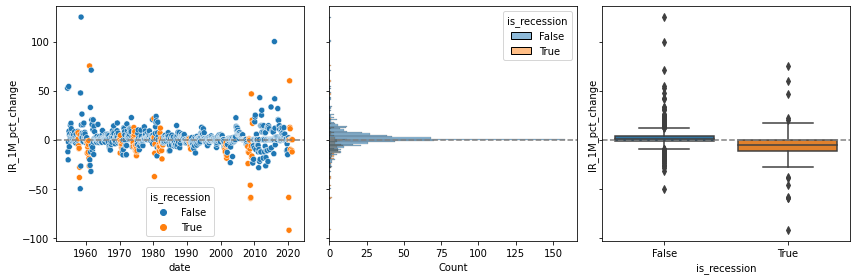

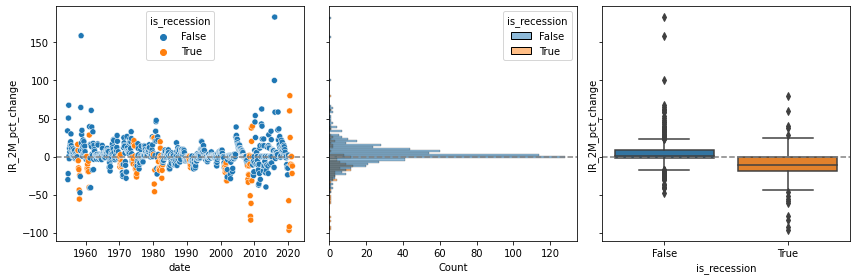

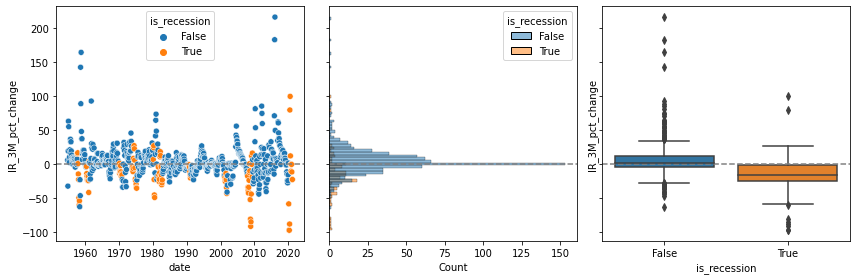

In [164]:
subset = ['IR_1M_pct_change', 'IR_2M_pct_change', 'IR_3M_pct_change']

plot_subset_together(subset)
plot_subset(subset)

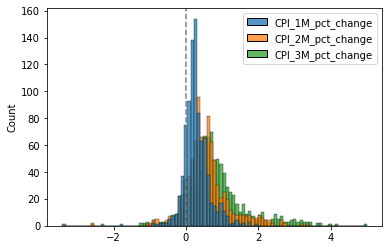

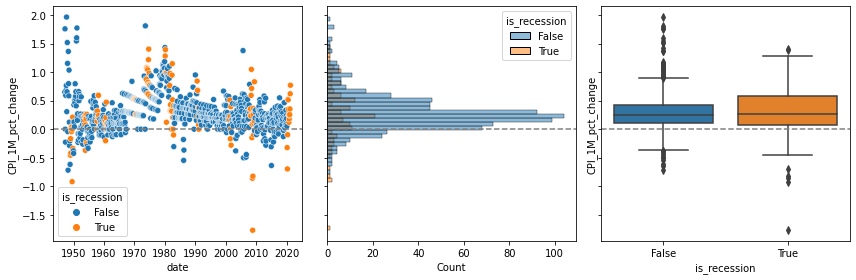

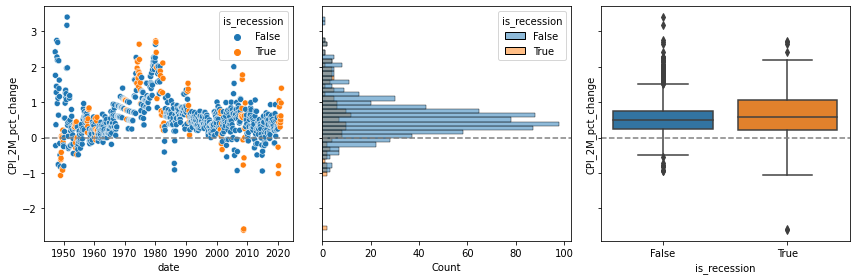

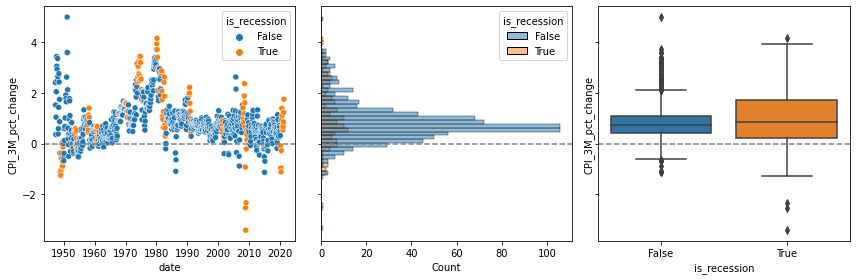

In [165]:
subset= ['CPI_1M_pct_change', 'CPI_2M_pct_change', 'CPI_3M_pct_change']

plot_subset_together(subset)
plot_subset(subset)

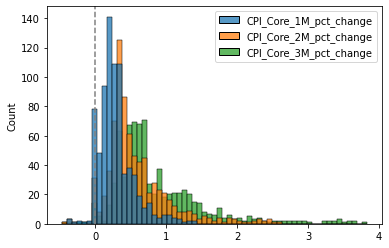

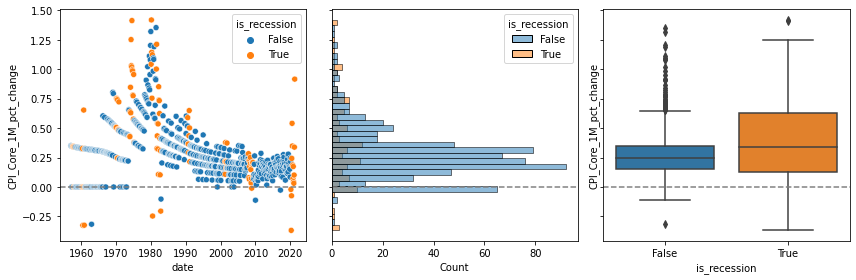

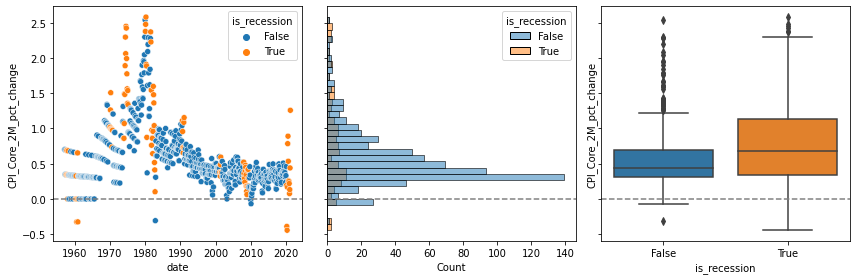

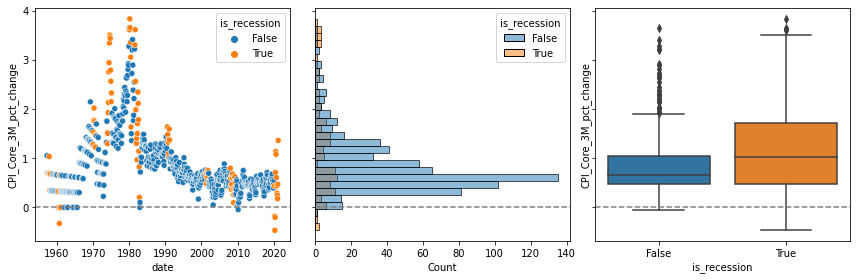

In [166]:
subset= ['CPI_Core_1M_pct_change', 'CPI_Core_2M_pct_change', 'CPI_Core_3M_pct_change']

plot_subset_together(subset)
plot_subset(subset)

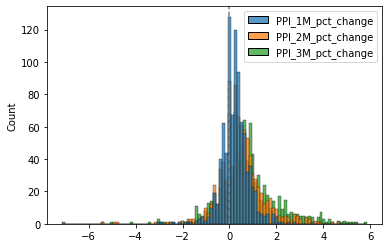

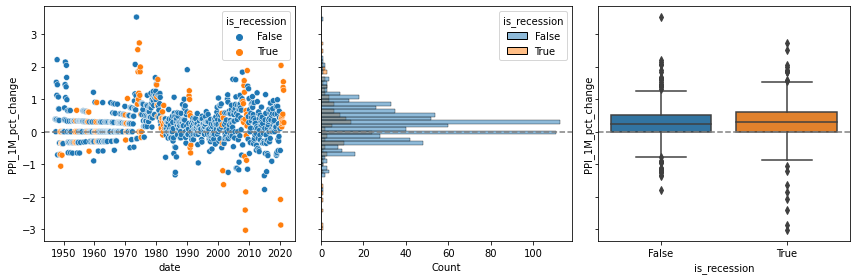

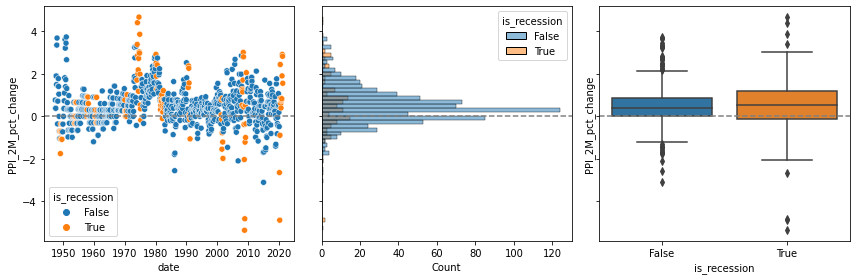

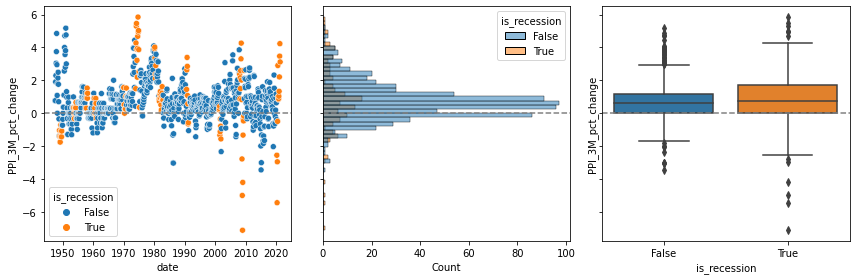

In [167]:
subset= ['PPI_1M_pct_change', 'PPI_2M_pct_change', 'PPI_3M_pct_change']

plot_subset_together(subset)
plot_subset(subset)

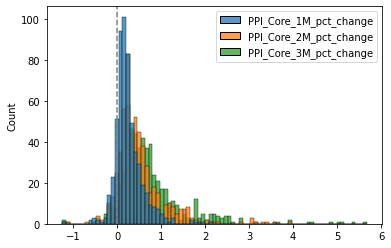

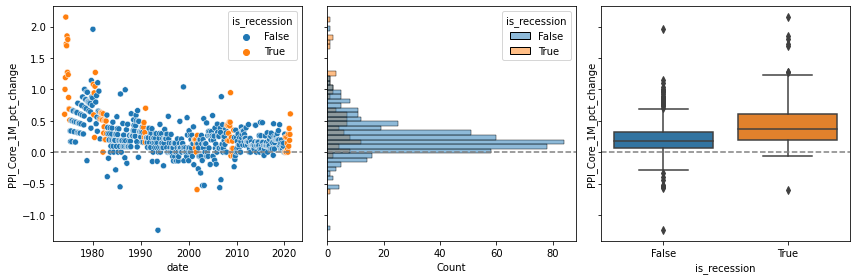

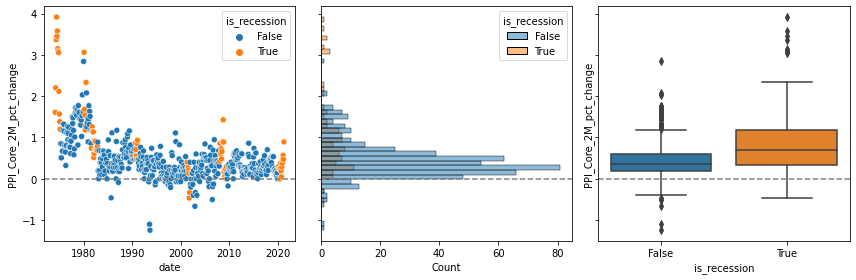

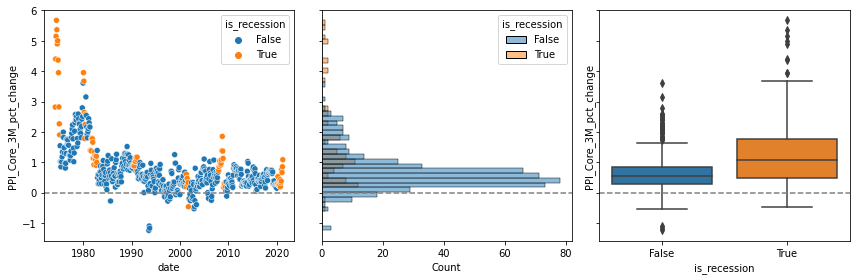

In [168]:
subset= ['PPI_Core_1M_pct_change', 'PPI_Core_2M_pct_change', 'PPI_Core_3M_pct_change']

plot_subset_together(subset)
plot_subset(subset)

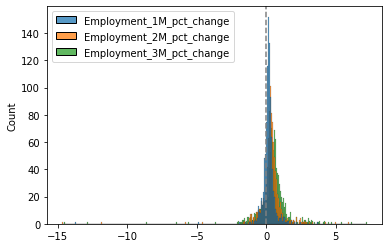

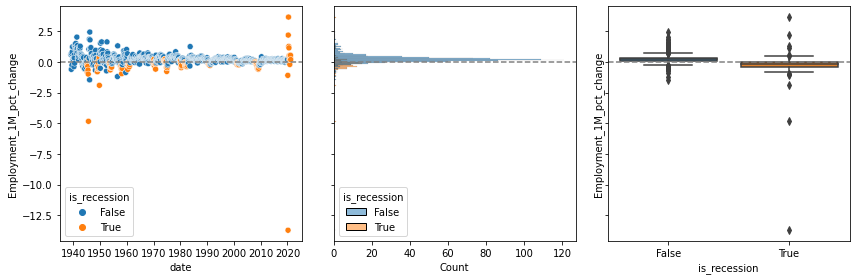

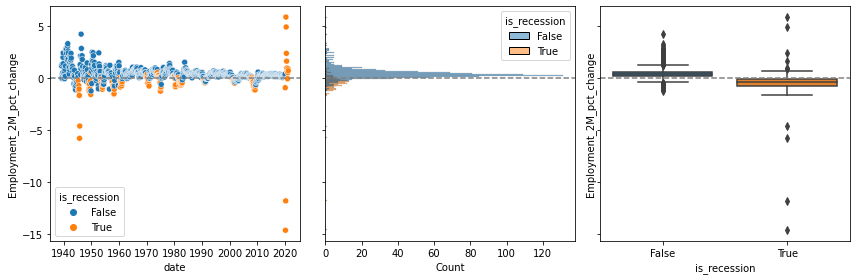

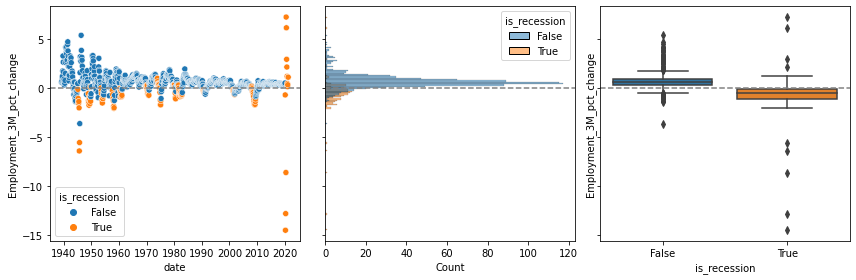

In [169]:
subset= ['Employment_1M_pct_change', 'Employment_2M_pct_change', 'Employment_3M_pct_change']

plot_subset_together(subset)
plot_subset(subset)

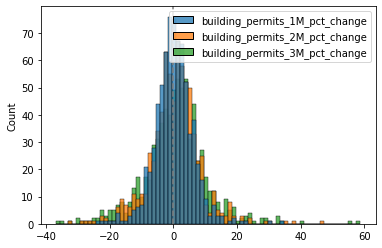

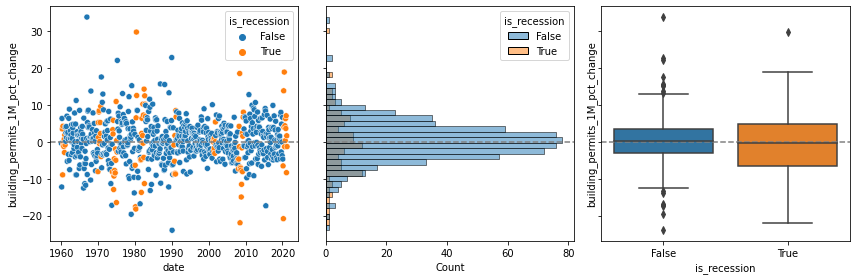

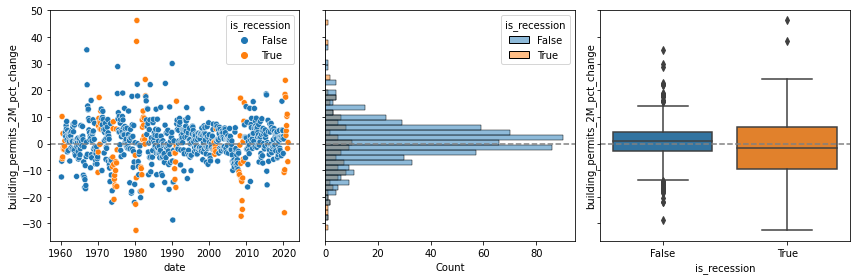

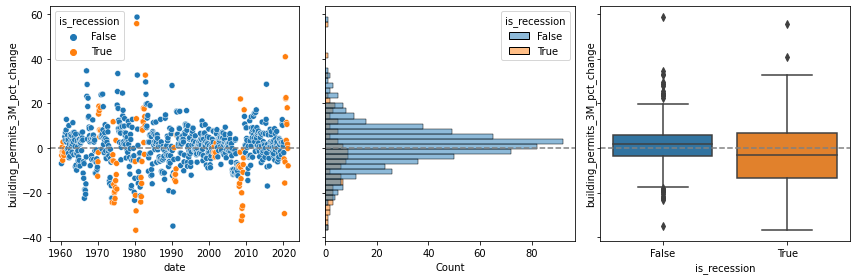

In [170]:
subset= ['building_permits_1M_pct_change', 'building_permits_2M_pct_change', 'building_permits_3M_pct_change']

plot_subset_together(subset)
plot_subset(subset)

##Soverign Default Risk Measures

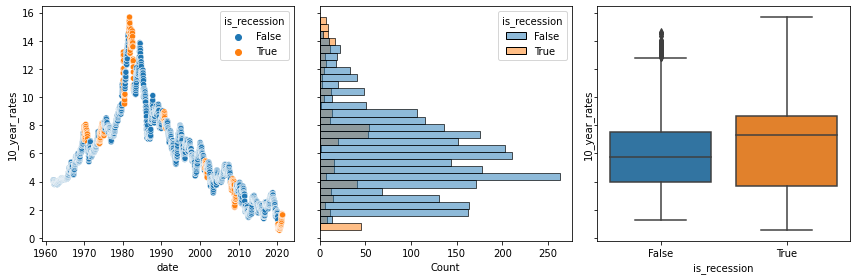

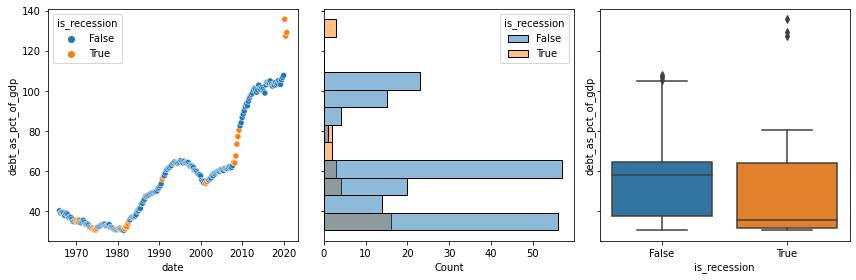

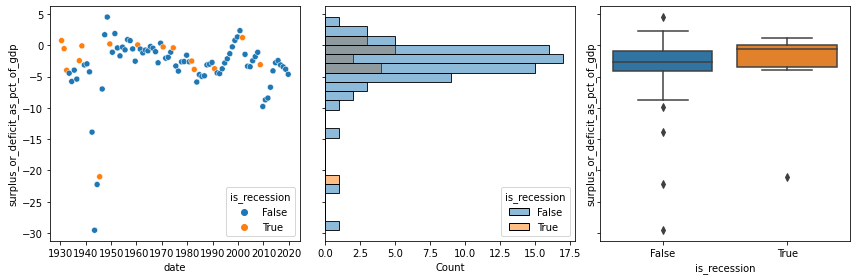

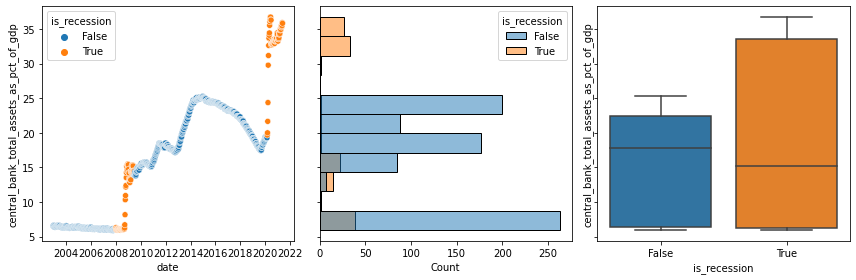

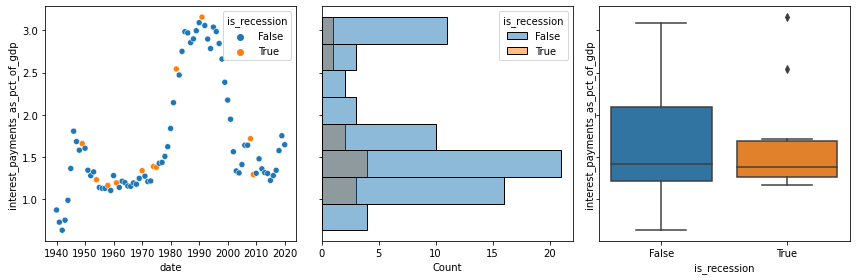

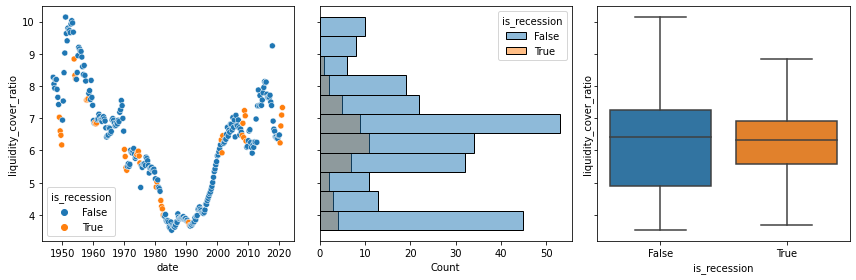

In [180]:
subset = [
        '10_year_rates',
        'debt_as_pct_of_gdp',
        'surplus_or_deficit_as_pct_of_gdp',
        'central_bank_total_assets_as_pct_of_gdp',
        'interest_payments_as_pct_of_gdp',
        'liquidity_cover_ratio',
        ]

plot_subset(subset, ref_line=None)

## Business and Consumer Sentiment indicators

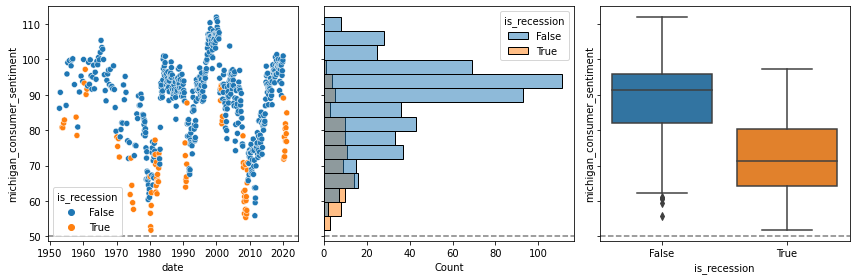

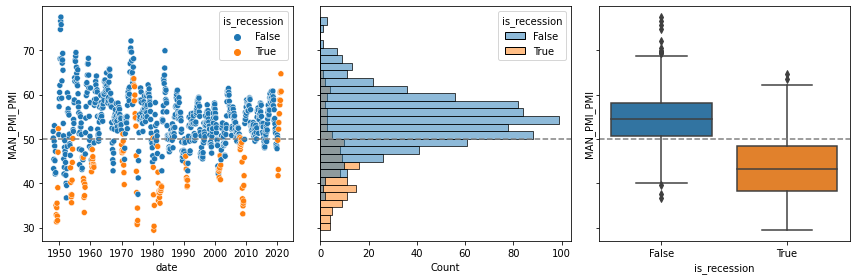

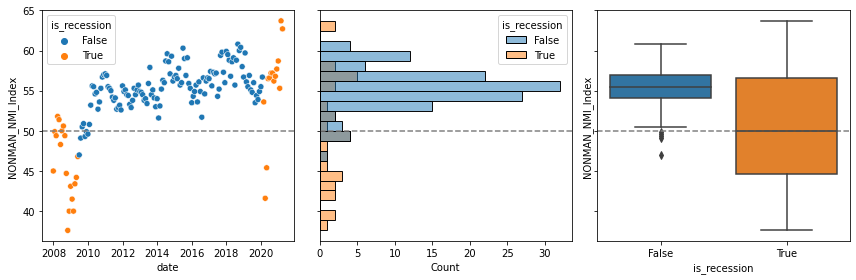

In [181]:
subset = [
          'michigan_consumer_sentiment', 
          'MAN_PMI_PMI', 
          'NONMAN_NMI_Index',
         ]

plot_subset(subset, ref_line=50)

# Modelling

## Trade-off between length of training period, and number of available data sources

Ideally, we'd like to train the model with all the data over the longest period possible. However, some data series are fairly new--less than 10 year old--while others have quite a long history spanning multiple decades. 

In [216]:
first_valid_loc = df.apply(lambda col: col.first_valid_index())
first_valid_loc.sort_values()

is_recession                              1900-01-01
surplus_or_deficit_as_pct_of_gdp          1930-06-30
Employment_1M_pct_change                  1939-02-01
Employment_2M_pct_change                  1939-03-01
Employment_3M_pct_change                  1939-04-01
interest_payments_as_pct_of_gdp           1940-01-01
liquidity_cover_ratio                     1947-01-01
CPI_1M_pct_change                         1947-02-01
CPI_2M_pct_change                         1947-03-01
gdp_growth                                1947-04-01
CPI_3M_pct_change                         1947-04-01
PPI_1M_pct_change                         1947-05-01
PPI_2M_pct_change                         1947-06-01
PPI_3M_pct_change                         1947-07-01
MAN_PMI_PMI                               1948-01-01
michigan_consumer_sentiment               1952-11-01
IR_1M_pct_change                          1954-08-01
IR_2M_pct_change                          1954-09-01
IR_3M_pct_change                          1954



We will work around this trade-off by slicing the training data so that it starts at various times in history. Longer training periods (starting earlier) will have fewer data series, while shorter training peroids (starting later) will have access tom more data series. It will be useful to see if the few long-running data series are more useful than abundance of newly-introduced data series when predicting the GDP. 

In [217]:
start_dates = first_valid_loc.sort_values().values
start_dates

array(['1900-01-01T00:00:00.000000000', '1930-06-30T00:00:00.000000000',
       '1939-02-01T00:00:00.000000000', '1939-03-01T00:00:00.000000000',
       '1939-04-01T00:00:00.000000000', '1940-01-01T00:00:00.000000000',
       '1947-01-01T00:00:00.000000000', '1947-02-01T00:00:00.000000000',
       '1947-03-01T00:00:00.000000000', '1947-04-01T00:00:00.000000000',
       '1947-04-01T00:00:00.000000000', '1947-05-01T00:00:00.000000000',
       '1947-06-01T00:00:00.000000000', '1947-07-01T00:00:00.000000000',
       '1948-01-01T00:00:00.000000000', '1952-11-01T00:00:00.000000000',
       '1954-08-01T00:00:00.000000000', '1954-09-01T00:00:00.000000000',
       '1954-10-01T00:00:00.000000000', '1957-02-01T00:00:00.000000000',
       '1957-03-01T00:00:00.000000000', '1957-04-01T00:00:00.000000000',
       '1960-02-01T00:00:00.000000000', '1960-03-01T00:00:00.000000000',
       '1960-04-01T00:00:00.000000000', '1962-01-05T00:00:00.000000000',
       '1966-01-01T00:00:00.000000000', '1974-02-01

## Decision Tree

Decision Tree Regressor test scores at various start dates


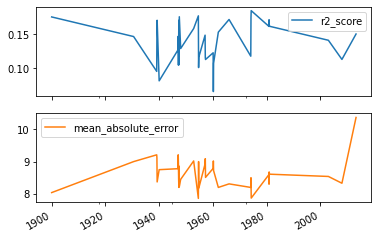

In [206]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

scores_df = pd.DataFrame(index=start_dates, columns=['r2_score', 'mean_absolute_error'])
for start_date in start_dates:
  X = df.loc[start_date:].drop(columns=['gdp_growth', 'is_recession']).fillna(method='ffill').dropna()
  y = df['gdp_growth']
  Xy = X.join(y).dropna()
  X = Xy.drop(columns=['gdp_growth'])
  y = Xy['gdp_growth']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

  regressor = DecisionTreeRegressor()
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  # print(f'r2_score: {r2}')
  scores_df.loc[start_date, 'r2_score'] = r2
  mae = mean_absolute_error(y_test, y_pred)
  # print(f'mean_absolute_error: {mae}')
  scores_df.loc[start_date, 'mean_absolute_error'] = mae
print('Decision Tree Regressor test scores at various start dates')
scores_df.plot(subplots=True);


## Linear Regression

r2_score: -0.9214891632786955
mean_absolute_error: 15.191782838521767
r2_score: -6.75899615196637
mean_absolute_error: 20.374502283482762
r2_score: -6.75899615196637
mean_absolute_error: 20.374502283482762
r2_score: -6.75899615196637
mean_absolute_error: 20.374502283482762
r2_score: -6.75899615196637
mean_absolute_error: 20.374502283482762
r2_score: -6.75899615196637
mean_absolute_error: 20.374502283482762
r2_score: -6.75899615196637
mean_absolute_error: 20.374502283482762
r2_score: -6.75899615196637
mean_absolute_error: 20.374502283482762
r2_score: -6.75899615196637
mean_absolute_error: 20.374502283482762
r2_score: -6.75899615196637
mean_absolute_error: 20.374502283482762
r2_score: -6.75899615196637
mean_absolute_error: 20.374502283482762
r2_score: -6.75899615196637
mean_absolute_error: 20.374502283482762
r2_score: -6.75899615196637
mean_absolute_error: 20.374502283482762
r2_score: -6.75899615196637
mean_absolute_error: 20.374502283482762
r2_score: -6.75899615196637
mean_absolute_erro

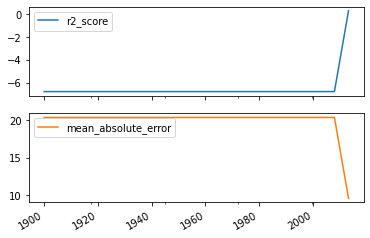

In [210]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Needs scaling
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print(f'r2_score: {r2_score(y_test, y_pred)}')
print(f'mean_absolute_error: {mean_absolute_error(y_test, y_pred)}')
regressor.coef_

scores_df = pd.DataFrame(index=start_dates, columns=['r2_score', 'mean_absolute_error'])
for start_date in start_dates:
  X = df.loc[start_date:].drop(columns=['gdp_growth', 'is_recession']).fillna(method='ffill').dropna()
  y = df['gdp_growth']
  Xy = X.join(y).dropna()
  X = Xy.drop(columns=['gdp_growth'])
  y = Xy['gdp_growth']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  regressor = LinearRegression()
  regressor.fit(X_train_scaled, y_train)
  y_pred = regressor.predict(X_test_scaled)
  r2 = r2_score(y_test, y_pred)
  print(f'r2_score: {r2}')
  scores_df.loc[start_date, 'r2_score'] = r2
  mae = mean_absolute_error(y_test, y_pred)
  print(f'mean_absolute_error: {mae}')
  scores_df.loc[start_date, 'mean_absolute_error'] = mae
print('Decision Tree Regressor test scores at various start dates')
scores_df.plot(subplots=True);


## hcrystalball: a time-series modelling module that unifies the api of various modelling modules

In [214]:
from hcrystalball.wrappers import get_sklearn_wrapper
from hcrystalball.compose import TSColumnTransformer
from hcrystalball.feature_extraction import SeasonalityTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = df.drop(columns=['gdp_growth', 'is_recession']).fillna(method='ffill').dropna()
y = df['gdp_growth']

from hcrystalball.model_selection import ModelSelector

ms = ModelSelector(horizon=1,
                   frequency='Q'
                  )

ms.create_gridsearch(sklearn_models=True,
                    n_splits = 10,
                    # between_split_lag=0,
                    sklearn_models_optimize_for_horizon=False,
                    autosarimax_models=False,
                    prophet_models=True,
                    tbats_models=True,
                    exp_smooth_models=True,
                    average_ensembles=False,
                    stacking_ensembles=False,
                    exog_cols=list(X.select_dtypes(include=np.number).columns),
#                     holidays_days_before=2,
#                     holidays_days_after=1,
#                     holidays_bridge_days=True,
                    )

#SkLearn models
from hcrystalball.wrappers import get_sklearn_wrapper

# Most sklearn models benefit from scaling of numeric features
sklearn_native_transformers = TSColumnTransformer(
    transformers=[
        ('scaler', 
          StandardScaler(), 
          list(X.select_dtypes(include=np.number).columns)
        )
        ])

# Decision Tree 
from sklearn.tree import DecisionTreeRegressor
ms.add_model_to_gridsearch(
    Pipeline([
            ('sklearns_native_transformers', sklearn_native_transformers),
            ('model', get_sklearn_wrapper(DecisionTreeRegressor, name='dt'))
            ]))

# Random Forest
from sklearn.ensemble import RandomForestRegressor
ms.add_model_to_gridsearch(
    Pipeline([
            ('sklearns_native_transformers', sklearn_native_transformers),
            ('model', get_sklearn_wrapper(RandomForestRegressor, name='rf'))
            ]))

# Linear Regression
from sklearn.linear_model import LinearRegression
ms.add_model_to_gridsearch(
    Pipeline([
            ('sklearns_native_transformers', sklearn_native_transformers),
            ('model', get_sklearn_wrapper(LinearRegression, name='lr'))
            ]))



# from hcrystalball.wrappers import SarimaxWrapper
# ms.add_model_to_gridsearch(SarimaxWrapper(init_with_autoarima=True))

from hcrystalball.wrappers import ProphetWrapper
ms.add_model_to_gridsearch(ProphetWrapper())

from hcrystalball.wrappers import ExponentialSmoothingWrapper
ms.add_model_to_gridsearch(ExponentialSmoothingWrapper())

from hcrystalball.wrappers import TBATSWrapper
ms.add_model_to_gridsearch(TBATSWrapper())

# from hcrystalball.wrappers import SimpleSmoothingWrapper
# from hcrystalball.wrappers import HoltSmoothingWrapper
# from hcrystalball.wrappers import BATSWrapper

ms.select_model(df=Xy,
                target_col_name='gdp_growth',
                # persist_model_selector_results=False,
                # output_path='my_results',
               )

Select Models:   0%|          | 0/1 [00:00<?, ?it/s]

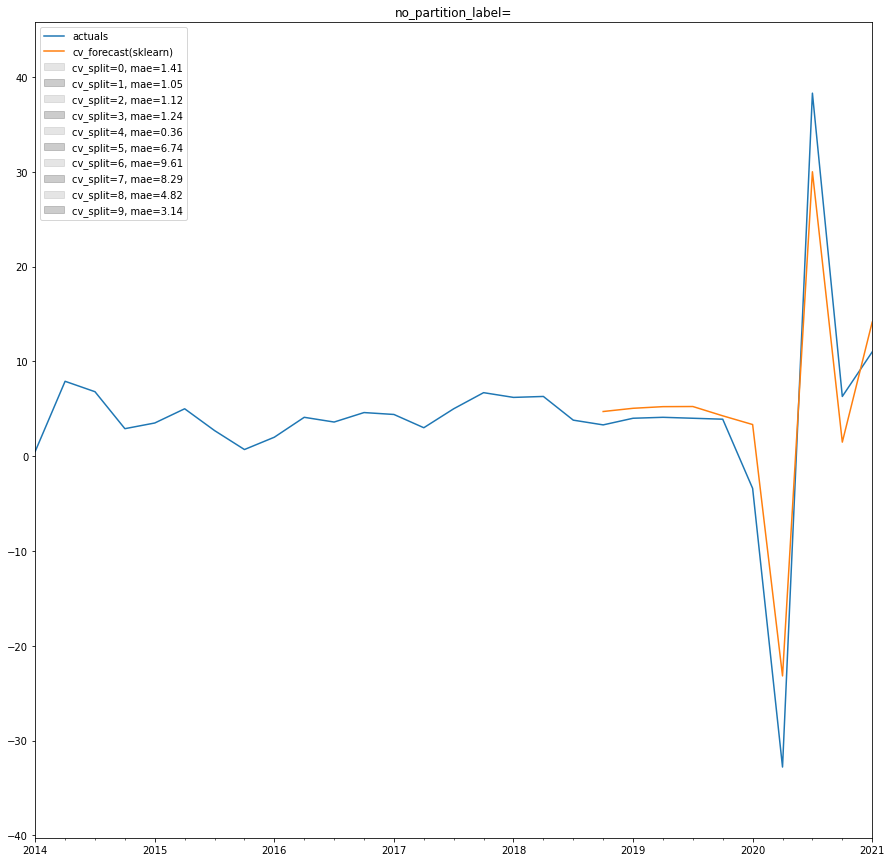

In [222]:
ms.plot_results(plot_from='2010', figsize=(15,15));

In [228]:
import pprint

In [249]:
ms.results[0].cv_results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__model,param_model__model__lags,param_model__model__optimize_for_horizon,param_model__seasonality__weekly,param_model__model__max_depth,param_model__extra_regressors,param_model__seasonality_mode,param_model__extra_seasonalities,param_model__damped_trend,param_model__fit_params,param_model__seasonal,param_model__trend,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
6,0.018013,0.001042,0.059440,0.003709,"(SeasonalityTransformer(auto=True, freq='Q', m...","SklearnWrapper(alpha=1.0, clip_predictions_low...",14,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': (SeasonalityTransformer(auto=True, f...",-1.411581,-1.050705,-1.124033,-1.238254,-0.357289,-6.736574,-9.614099,-8.292975,-4.819170,-3.142472,-3.778715,3.208104,1
7,0.014938,0.001335,0.059120,0.004338,"(SeasonalityTransformer(auto=True, freq='Q', m...","SklearnWrapper(alpha=1.0, clip_predictions_low...",14,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': (SeasonalityTransformer(auto=True, f...",-1.411581,-1.050705,-1.124033,-1.238254,-0.357289,-6.736574,-9.614099,-8.292975,-4.819175,-3.142473,-3.778716,3.208104,2
2,0.017695,0.000470,0.057010,0.001489,"(SeasonalityTransformer(auto=True, freq='Q', m...","SklearnWrapper(alpha=1.0, clip_predictions_low...",7,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': (SeasonalityTransformer(auto=True, f...",-1.563777,-0.737862,-0.001819,-0.231841,-0.055239,-7.188604,-10.195815,-18.595441,-12.178331,-4.864342,-5.561307,6.059373,3
3,0.014846,0.001924,0.054799,0.006721,"(SeasonalityTransformer(auto=True, freq='Q', m...","SklearnWrapper(alpha=1.0, clip_predictions_low...",7,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': (SeasonalityTransformer(auto=True, f...",-1.563777,-0.737862,-0.001819,-0.231841,-0.055239,-7.188604,-10.195815,-18.595441,-12.178358,-4.864348,-5.561310,6.059375,4
5,0.014386,0.001115,0.053658,0.002197,"(SeasonalityTransformer(auto=True, freq='Q', m...","SklearnWrapper(alpha=1.0, clip_predictions_low...",10,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': (SeasonalityTransformer(auto=True, f...",-0.966005,-0.850964,-0.548190,-0.196804,-0.739595,-7.154594,-16.632154,-18.681986,-10.725951,-8.349543,-6.484579,6.660632,5
4,0.018944,0.001728,0.059988,0.004587,"(SeasonalityTransformer(auto=True, freq='Q', m...","SklearnWrapper(alpha=1.0, clip_predictions_low...",10,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': (SeasonalityTransformer(auto=True, f...",-0.966005,-0.850964,-0.548190,-0.196804,-0.739595,-7.154594,-16.632154,-18.681986,-10.725952,-8.349543,-6.484579,6.660632,6
0,0.020484,0.005511,0.058363,0.003404,"(SeasonalityTransformer(auto=True, freq='Q', m...","SklearnWrapper(alpha=1.0, clip_predictions_low...",3,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': (SeasonalityTransformer(auto=True, f...",-1.568389,-0.211199,-0.282658,-0.035301,-0.249005,-7.459854,-16.414520,-26.045365,-13.061261,-3.478777,-6.880633,8.457907,7
1,0.015310,0.001450,0.053624,0.005600,"(SeasonalityTransformer(auto=True, freq='Q', m...","SklearnWrapper(alpha=1.0, clip_predictions_low...",3,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': (SeasonalityTransformer(auto=True, f...",-1.568389,-0.211199,-0.282658,-0.035301,-0.249005,-7.459854,-16.414520,-26.045365,-13.061258,-3.478883,-6.880643,8.457902,8
13,0.014768,0.001273,0.182450,0.007455,"(SeasonalityTransformer(auto=True, freq='Q', m...","SklearnWrapper(bootstrap=True, ccp_alpha=0.0, ...",10,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': (SeasonalityTransformer(auto=True, f...",-1.397000,-0.056000,-0.672000,-0.368000,-0.204000,-7.540000,-33.578000,-45.136000,-1.705000,-4.318000,-9.497400,15.309218,9
12,0.018495,0.001104,0.185065,0.004564,"(SeasonalityTransformer(auto=True, freq='Q', m...",

In [250]:
ms.results[0].best_model_cv_results

mean_fit_time                                                                       0.0180132
std_fit_time                                                                       0.00104158
mean_score_time                                                                     0.0594398
std_score_time                                                                     0.00370896
param_model                                 (SeasonalityTransformer(auto=True, freq='Q', m...
param_model__model                          SklearnWrapper(alpha=1.0, clip_predictions_low...
param_model__model__lags                                                                   14
param_model__model__optimize_for_horizon                                                False
param_model__seasonality__weekly                                                         True
param_model__model__max_depth                                                             NaN
param_model__extra_regressors                               